# Joint lightcurve - radial velocity model with individual priors

In [1]:
import lightkurve as lk
import astropy.table as astab
import pandas as pd
import numpy as np
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
# %pylab inline
# pylab.rcParams['figure.figsize'] = (16, 8)
import warnings
import astropy.table as astab
from astropy.io import fits

from helper_functions import *

warnings.filterwarnings('ignore',
    message="WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size:"
)
print(astropy.__version__)

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo

import arviz as az
from corner import corner

from scipy.signal import savgol_filter

# %matplotlib widget
# dd = "/Users/kjaehnig/CCA_work/GAT/"

def docs_setup():
    """Set some environment variables and ignore some warnings for the docs"""
    import logging
    import warnings


    # Remove when Theano is updated
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Remove when arviz is updated
    warnings.filterwarnings("ignore", category=UserWarning)

    logger = logging.getLogger("theano.gof.compilelock")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("theano.tensor.opt")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("exoplanet")
    logger.setLevel(logging.DEBUG)

docs_setup()

running on macOS
4.3.1


## PYMC3 BUILD

There is already a directory for TIC 28159019.
0.001388888888888889 120.00000000000003
1.1389999999998963
lightcurve N datapoints:  10745 10745 10745 transit_epoch:  1.1389999999998963
3.3133538
165.0
There is already a directory for TIC 28159019.
ecosw_tv:  -0.4592753693392572
sigma_lc ~ InverseGamma sigma_gp ~ InverseGamma rho_gp ~ InverseGamma
mean_lc                           -3.22
mean_rv                           -4.83
u1_quadlimbdark__                 -2.77
u2_quadlimbdark__                 -2.77
log_M1                             1.33
log_R1                             1.21
log_k                              0.14
log_q                              0.87
log_s                              0.41
b_impact__                        -1.58
t0                                -0.92
tn                                -0.92
ecs_unitdisk+interval__           -1.40
sigma_lc_log__                    -3.05
sigma_gp_log__                    -2.69
rho_gp_log__                      -4.11
log_sigma_r

optimizing logp for variables: [log_k]


message: Optimization terminated successfully.
logp: -2014686.1135405004 -> -88992.78219856086
optimizing logp for variables: [b, log_k]


message: Optimization terminated successfully.
logp: -88992.78219856086 -> -88463.81100306941
optimizing logp for variables: [ecs]


message: Desired error not necessarily achieved due to precision loss.
logp: -88463.81100306941 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model



--------------------------------------------------
N_best: 1, N_left: 9, log_q
--------------------------------------------------
N_best: 2, N_left: 8, log_s
--------------------------------------------------
N_best: 3, N_left: 7, log_R1
--------------------------------------------------
N_best: 4, N_left: 6, u1_u2
--------------------------------------------------
N_best: 5, N_left: 5, ecs
--------------------------------------------------
N_best: 6, N_left: 4, t0_tn
--------------------------------------------------
N_best: 7, N_left: 3, lsig_rv
--------------------------------------------------
N_best: 8, N_left: 2, log_M1
--------------------------------------------------
N_best: 9, N_left: 1, mean_rv
--------------------------------------------------
N_best: 10, N_left: 0, mean_lc


optimizing logp for variables: [rho_gp, sigma_gp, sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -28794.695477474423 -> -27005.71332291633
optimizing logp for variables: [log_sigma_rv, rho_gp, sigma_gp, sigma_lc, ecs, tn, t0, b, log_s, log_q, log_k, log_R1, log_M1, u2, u1, mean_rv, mean_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -27005.71332291633 -> -25948.064068896


NameError: name 'sys_destst' is not defined

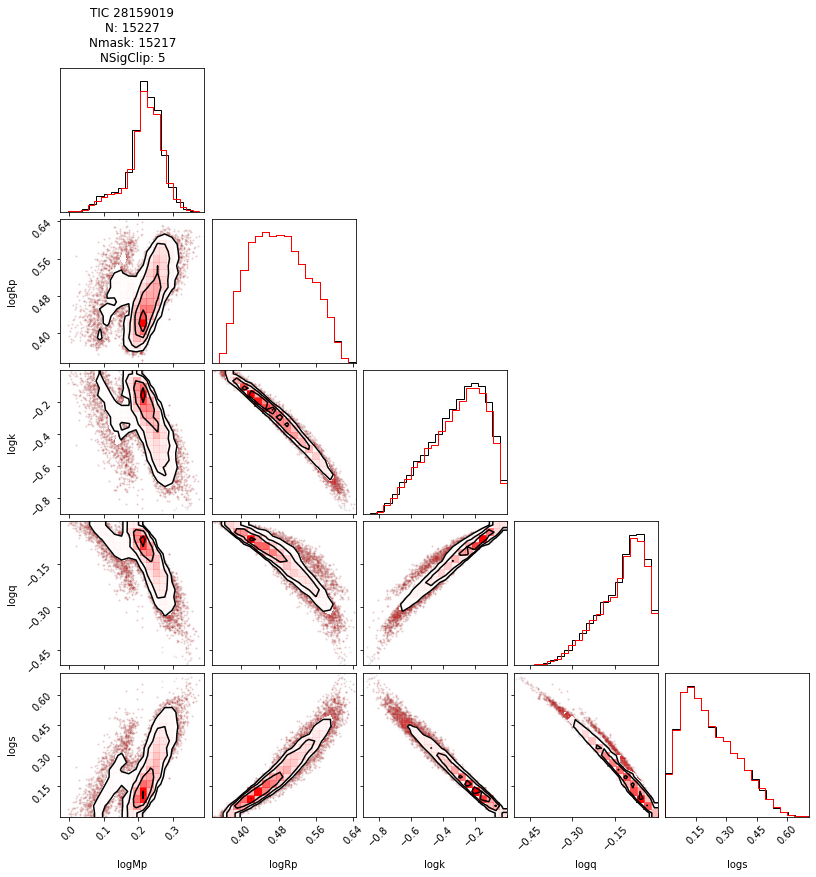

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

In [3]:

TIC_TARGET = "TIC 28159019"
mf = 2


pymc3_model_dict = load_all_data_for_pymc3_model(TIC_TARGET, sparse_factor=5, nsig=5, save_data_to_dict=True)
# file = open(f"{TIC_TARGET.replace(' ','_').replace('-','_')}_sf5_pymc3_data_dict","rb")
# pymc3_model_dict = pk.load(file)
# file.close()

sys_dest,fig_dest = check_for_system_directory(TIC_TARGET, return_directories=True)

texp = pymc3_model_dict['texp']
x_rv, y_rv, yerr_rv = pymc3_model_dict['x_rv'], pymc3_model_dict['y_rv'], pymc3_model_dict['yerr_rv']
x, y, yerr = pymc3_model_dict['x'], pymc3_model_dict['y'], pymc3_model_dict['yerr']
lk_sigma = pymc3_model_dict['lk_sigma']

lit_period, lit_t0, lit_tn = pymc3_model_dict['lit_period'], pymc3_model_dict['lit_t0'], pymc3_model_dict['lit_tn']
Ntrans, ecosw_tv = pymc3_model_dict['Ntrans'], pymc3_model_dict['ecosw_tv']
print('ecosw_tv: ', ecosw_tv)
if abs(ecosw_tv) > 0.01:
    ecosw_tv = np.sign(ecosw_tv) * 0.01


LOGiso_M1 = pymc3_model_dict['isores']['logm1']
LOGiso_R1 = pymc3_model_dict['isores']['logr1']
LOGiso_q = pymc3_model_dict['isores']['logq']
LOGiso_k = pymc3_model_dict['isores']['logk']
LOGiso_s = pymc3_model_dict['isores']['logs']


t = np.linspace(x_rv.min(), x_rv.max(), 5000)
tlc = np.linspace(x.min(), x.max(), 5000)

# rvK = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv*u.km/u.s, yerr_rv*u.km/u.s, t0s=bls_t0)[0]
# print(rvK)

# mask = x < 400
def build_model(mask=None, start=None, plot_MAP_diagnostic_rv_curves=False):
    if mask is None:
        mask = np.ones(len(x), dtype='bool')
    with pm.Model() as model:

        # Systemic parameters
        mean_lc = pm.Normal("mean_lc", mu=0.0, sd=10.0)
        mean_rv = pm.Normal("mean_rv", mu=0.0, sd=50.0)

        u1 = xo.QuadLimbDark("u1")
        u2 = xo.QuadLimbDark("u2")

        # Parameters describing the primary
        log_M1 = pm.Normal("log_M1", mu=LOGiso_M1[0], sigma=mf*LOGiso_M1[1], testval=LOGiso_M1[0])
        log_R1 = pm.Normal("log_R1", mu=LOGiso_R1[0], sigma=mf*LOGiso_R1[1], testval=LOGiso_R1[0])

        M1 = pm.Deterministic("M1", tt.exp(log_M1))
        R1 = pm.Deterministic("R1", tt.exp(log_R1))

        
        # Secondary ratios
        log_k = pm.Normal("log_k", mu=LOGiso_k[0], sigma=mf*LOGiso_k[1], testval = LOGiso_k[0])  # radius ratio        
        log_q = pm.Normal("log_q", mu=LOGiso_q[0], sigma=mf*LOGiso_q[1], testval = LOGiso_q[0])  # mass ratio
        log_s = pm.Normal("log_s", mu=LOGiso_s[0], sigma=mf*LOGiso_s[1], testval = LOGiso_s[0])  # surface brightness ratio
  
        
        k = pm.Deterministic("k", tt.exp(log_k))
        q = pm.Deterministic("q", tt.exp(log_q))
        s = pm.Deterministic("s", tt.exp(log_s))


        # Parameters describing the orbit
        b = xo.ImpactParameter("b", ror=k, testval=0.5)

#         log_period = pm.Normal("log_period", mu=np.log(lit_period), sigma=5.0)
#         period = pm.Deterministic("period", tt.exp(log_period))
        t0 = pm.Normal("t0", mu=lit_t0, sigma=1.0)
        tn = pm.Normal("tn", mu=lit_tn, sigma=1.0)
        period = pm.Deterministic("period", (tn - t0) / Ntrans)
        # Parameters describing the eccentricity: ecs = [e * cos(w), e * sin(w)]
#         ecosw_tv=0.01
        sqrt_ecosw = np.sign(ecosw_tv) * np.sqrt(abs(ecosw_tv))
        # ecs is now sqrt(ecs) even if variable name is still ecs
        ecs = pmx.UnitDisk("ecs", testval=np.array([sqrt_ecosw, 0.0]))
        # remove sqrt from ecc, rewrite as ecosW and esinW
        
        
        
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # Build the orbit
        R2 = pm.Deterministic("R2", tt.exp(log_k + log_R1))
        M2 = pm.Deterministic("M2", tt.exp(log_q + log_M1))
        orbit = xo.orbits.KeplerianOrbit(
            period=period,
            t0=t0,
            ecc=ecc,
            omega=omega,
            b=b,
            r_star=R1,
            m_star=M1,
            m_planet=M2,
        )

        # Track some other orbital elements
        pm.Deterministic("incl", orbit.incl)
        pm.Deterministic("a", orbit.a)
        
        
        
        
        # Noise model for the light curve
        
        
        
        sigma_lc = pm.InverseGamma(
            "sigma_lc",
            testval= np.mean(yerr),
            **pmx.estimate_inverse_gamma_parameters(0.1,5.0)
        )
        
        
        sigma_gp = pm.InverseGamma(
            "sigma_gp",
            testval= lk_sigma,
            **pmx.estimate_inverse_gamma_parameters(0.1,10.0),
        )
        rho_gp = pm.InverseGamma(
            "rho_gp",
            testval= 2.0 * lit_period,
            **pmx.estimate_inverse_gamma_parameters(0.1,10.0)
        )
#         sigma_lc = np.mean(yerr)
#         sigma_gp = lk_sigma
#         rho_gp = 0.25*lit_period
        print(sigma_lc, sigma_gp, rho_gp)
        kernel_lc = terms.SHOTerm(sigma=sigma_gp, rho=rho_gp, Q=1.0 / 3.)

#         # Noise model for the radial velocities
#         sigma_rv = pm.InverseGamma(
#             "sigma_rv",
#             testval=1.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 15.0)
#         )
#         sigma_rv_gp = pm.InverseGamma(
#             "sigma_rv_gp",
#             testval=1.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 15.0)
#         )
#         rho_rv_gp = pm.InverseGamma(
#             "rho_rv_gp",
#             testval=2.0,
#             **pmx.estimate_inverse_gamma_parameters(0.1, 25.0)
#         )
#         kernel_rv = terms.SHOTerm(sigma=sigma_rv_gp, w0=rho_rv_gp, Q=1.0 / 3.)

        # Set up the light curve model
        lc = xo.SecondaryEclipseLightCurve(u1, u2, tt.exp(log_s))

        def model_lc(t):
            return (
                mean_lc
                + 1e3
                * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:,0]
            )

#         pm.Deterministic(
#             "lc_pred",
#             model_lc(x)
#         )
        
        # Condition the light curve model on the data
        gp_lc = GaussianProcess(kernel_lc, t=x[mask], yerr=sigma_lc)
        gp_lc.marginal("obs_lc", observed=y[mask] - model_lc(x[mask]))


#         # Set up the radial velocity model

        log_sigma_rv =  pm.Bound(pm.Normal, upper=np.log(10))(
            "log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=10.0, testval=np.log(np.median(yerr_rv))
        )

        def model_rv(t):
            return orbit.get_radial_velocity(t, output_units=u.km/u.s) + mean_rv
            
        rv_model = model_rv(x_rv)
        
#         def model_K(t, period, t0):
#             rvs = model_rv(t)
#             modK = xo.estimate_semi_amplitude(period, t, rvs, yerr_rv, t0).to(u.km/u.s)
#             return modK
        
        err = tt.sqrt(yerr_rv**2. + tt.exp(2*log_sigma_rv))
        
        pm.Normal("obs",mu=rv_model, sd=err, observed=y_rv)

        ## compute phased RV signal
#         n = 2.*np.pi * (1./period)
#         phi = (t0 * n) - omega
#         phase = np.linspace(0, 1, 500)
#         M_pred = 2 * np.pi * phase - (phi + omega)
#         f_pred = xo.orbits.get_true_anomaly(M_pred, ecc + tt.zeros_like(M_pred))
        
# #         K = xo.estimate_semi_amplitude(period, t, rv_model, yerr_rv, t0).to(u.km/u.s)
#         K = (tt.max(rv_model) - tt.min(rv_model)) / 2.
    
#         rvphase = pm.Deterministic(
#             "rvphase", K * (tt.cos(omega) * (tt.cos(f_pred) + ecc) - tt.sin(omega) * tt.sin(f_pred))
#         )
#         n = 2.*np.pi * (1./period)
#         phi = (t0 * n) - omega
#         phase = np.linspace(0, 1, 500)
#         M_pred = 2 * np.pi * phase - (phi + omega)
#         f_pred = xo.orbits.get_true_anomaly(M_pred, ecc + tt.zeros_like(M_pred))
        
# #         K = xo.estimate_semi_amplitude(period, t, rv_model, yerr_rv, t0).to(u.km/u.s)
#         K = (tt.max(rv_model) - tt.min(rv_model)) / 2.
    
#         rvphase = pm.Deterministic(
#             "rvphase", K * (tt.cos(omega) * (tt.cos(f_pred) + ecc) - tt.sin(omega) * tt.sin(f_pred))
#         )
        
        # Optimize the logp
        if start is None:
            start = model.test_point

            
        extras = dict(
            x=x[mask],
            y=y[mask],
            x_rv = x_rv,
            y_rv = y_rv,
            yerr_rv = yerr_rv,
            model_lc=model_lc,
            model_rv=model_rv,
            gp_lc_pred=gp_lc.predict(y[mask] - model_lc(x[mask])),
        )
        
        
        # First the RV parameters
        print(model.check_test_point())
        opti_logp = []
        filename_list = []
        map_vars_dict = {
            't0_tn' : [tn,t0],
            'u1_u2' : [u1, u2],
            'log_q' : log_q,
            'log_s' : log_s,
            'log_M1': log_M1,
            'log_R1': log_R1,
            'mean_lc': mean_lc,
            'mean_rv': mean_rv,
            'lsig_rv':log_sigma_rv
        }
        list_of_map_vars = list(map_vars_dict.keys())
        

        filename_base = f"{fig_dest}{TIC_TARGET.replace(' ','_')}_individual_priors"
        
        plot = plot_MAP_rv_curve_diagnostic_plot(model, start, extras, mask, 
                                                 title=' after start point opt step',
                                                 filename=filename_base + ' after start point opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)
        
        map_soln, info_ = pmx.optimize(start, log_k, return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title='after log_k opt step',
                                                 filename=filename_base + 'after log_k opt step.png'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)
        
        map_soln, info_ = pmx.optimize(map_soln, b, return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title=' after b opt step',
                                                 filename = filename_base + ' after b opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)




        map_soln, info_ = pmx.optimize(map_soln, ecs, return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title='model after [ecs] opt step',
                                                 filename=filename_base + ' model after [ecs] opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        ecs_logp = -info_['fun']
        filename_list.append(plot)
        if ~np.isfinite(-info_['fun']):
            list_of_map_vars.append('ecs')
            map_vars_dict['ecs'] = ecs
        
        

        best_map_list = []
        whileloop_failsafe = 0
        while len(list_of_map_vars) > 0:
            highest_logp = -np.inf
            try:
                next_map_var = []
                next_map_soln = []
                next_opti_logp = np.nan
                for ii in list_of_map_vars:
#                     print(f"optimizing {ii}") 
                    map_soln_ii, info_ = pmx.optimize(map_soln, map_vars_dict[ii], return_info=True, verbose=False)
                    
                    if np.isfinite(-info_['fun']):
                        if -info_['fun'] > highest_logp:
                            next_map_var = ii
                            next_map_soln = map_soln_ii
                            next_opti_logp = -info_['fun']
                            highest_logp = -info_['fun']
                            
                opti_logp.append(next_opti_logp)
                map_soln = next_map_soln
                list_of_map_vars.remove(next_map_var)
                best_map_list.append(next_map_var)
                
                print("-"*50)
                print(f"N_best: {len(best_map_list)}, N_left: {len(list_of_map_vars)}, {next_map_var}")
                plotn = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, title=f' after {next_map_var} opt step', 
                                                          filename=filename_base + f' after {next_map_var} opt step'.replace(' ','_'),
                                                          RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
                filename_list.append(plotn)

            except:
                print("loop failed")
                whileloop_failsafe += 1
                print(whileloop_failsafe)
            if whileloop_failsafe > 20:
                break


#         map_soln, info_ = pmx.optimize(map_soln, [u1,u2], return_info=True)
#         plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
#                                                  title=' after [u1, u2] opt step', 
#                                                  filename=filename_base + ' after [u1, u2] opt step'.replace(' ','_'),
#                                                  RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
#         filename_list.append(plot)
        
#         map_soln, info_ = pmx.optimize(map_soln, log_sigma_rv, return_info=True)
#         plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
#                                                  title=' after log_sigma_rv opt step',
#                                                  filename=filename_base+' after log_sigma_rv opt step'.replace(' ','_'),
#                                                  RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
#         filename_list.append(plot)
        
        
        map_soln, info_ = pmx.optimize(map_soln, [sigma_lc, sigma_gp, rho_gp], return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title=' after GP params opt step',
                                                 filename=filename_base + ' after GP params opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot)
        
        map_soln, info_ = pmx.optimize(map_soln, 
                                       return_info=True)
        plot = plot_MAP_rv_curve_diagnostic_plot(model, map_soln, extras, mask, 
                                                 title=' after final opt step',
                                                 filename=filename_base+' after final opt step'.replace(' ','_'),
                                                 RETURN_FILENAME=True, pymc3_model_dict=pymc3_model_dict)
        filename_list.append(plot) 






    return model, map_soln, extras, start, opti_logp, filename_list




model, map_soln, extras, start, opti_logp, filename_list = build_model(plot_MAP_diagnostic_rv_curves=True)

import imageio
images = []

filename_list.append(filename_list[-1])
filename_list.append(filename_list[-1])
filename_list.append(filename_list[-1])
filename_list.append(filename_list[-1])
for filename in filename_list:
    images.append(imageio.imread(filename))
imageio.mimsave(sys_dest+f"/{TIC_TARGET.replace(' ','_')}_{suffix}_individual_priors_diagnostic_movie_test.gif", images, fps=0.75)


print("#" * 50)
print("#"*19 +"  FINISHED  " + "#"*19)
print("#"*50)

In [39]:
file = open(f"/Users/kjaehnig/CCA_work/GAT/{TIC_TARGET}_joint_mod_individual_priors_map_soln.pickle",'wb')
pk.dump([map_soln,start], file)
file = open("tic28159019_joint_mod_individual_priors_map_soln.pickle",'wb')
pk.dump(map_soln, file)
file.close()

In [183]:
# print(np.exp(map_soln['log_period']),lit_period,(np.exp(map_soln['log_period'])-lit_period) )
# print(jk_row['MAP_P'])
# print(start.keys())
# print(best_map_list)
fig,ax = plt.subplots()
ax.plot(range(len(opti_logp)), opti_logp,'o-')


In [40]:
def plot_diagnostic_plots(soln, extras, mask, title,
                                        DO_NOT_SAVE=True):
    if mask is None:
        mask = np.ones(len(extras['x']), dtype=bool)
    
    if 'period' in soln.keys():
        period = soln['period']
    else:
        period = (soln['tn'] - soln['t0']) / Ntrans
    x = extras['x']
    y = extras['y']
    t_lc_pred = np.linspace(x.min(), x.max(), 3000) 
    
    t0 = soln['t0']
    mean = soln['mean_rv']
    x_phase = np.linspace(-0.5*period, 0.5*period, 1000)
    
    x_rv = extras['x_rv']
    y_rv = extras['y_rv']
    
    with model:
        gp_pred = (
            pmx.eval_in_model(extras["gp_lc_pred"], soln) + soln["mean_lc"]
        )
        lc = (
            pmx.eval_in_model(extras["model_lc"](x), soln)
            - soln["mean_lc"]
        )

        y_rv_mod = pmx.eval_in_model(extras['model_rv'](x_phase + t0), soln) - soln['mean_rv']
    
    # fig, axes = plt.subplots(nrows=3)
    gsfig = GridSpec(nrows=140,ncols=100)
    fig = plt.figure(figsize=(12,8), constrained_layout=False)

    fig, ax4 = plt.subplots(figsize=(12,18))

    ax1 = fig.add_subplot(gsfig[:30,:])
    ax2 = fig.add_subplot(gsfig[30:60,:])
    ax3 = fig.add_subplot(gsfig[70:100,:])
    ax4 = fig.add_subplot(gsfig[110:,:])
    
    ax1.tick_params(labelbottom=False,direction='in')
    ax2.tick_params(bottom=True,direction='in')

    ax1.plot(x, y, "k.", alpha=0.2)
    ax1.plot(x, gp_pred, color="C1", lw=1)
    ax1.plot(x,lc,'C2')

    ax1.set_xlim(x.min(),x.min()+10.)# x.max())
#     ax1.set_xlim(x.max()-10,x.max())# x.max())

#     ax2.plot(x, y - gp_pred, "k.", alpha=0.2)
#     ax2.plot(x, lc, color="C2", lw=1)
    ax2.plot(x, y-lc, color='C2', lw=2)
    
    ax2.set_xlim(x.min(),x.min()+10)# x.max())
#     ax2.set_xlim(x.max()-10,x.max())# x.max())
    
    ax1.set_ylabel("raw flux [ppt]")
    ax2.set_ylabel("de-trended flux [ppt]")
    ax2.set_xlabel("time [TBJD]")



    x_fold = (
        (extras["x"] - t0) % period / period
    )
    inds = np.argsort(x_fold)

    ax3.plot(x_fold[inds], extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
    ax3.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred[inds], "k.", alpha=0.2)
#     ax2.plot(
#         x_fold[mask][inds],
#         extras["y"][mask][inds] - gp_pred[mask][inds],
#         "k.",
#         alpha=0.2,
#         label="data!",
#     )
#     ax2.plot(x_fold[inds] - 1, extras["y"][inds] - gp_pred, "k.", alpha=0.2)

    yval = extras["y"][inds] - gp_pred
    bins = np.linspace(0, 1, 75)
    num, _ = np.histogram(x_fold[inds], bins, weights=yval)
    denom, _ = np.histogram(x_fold[inds], bins)
#     ax2.plot(0.5 * (bins[:-1] + bins[1:]) - 1, num / denom, ".w")

    args = dict(lw=1)

    x_fold = (x - t0) % period / period
    inds = np.argsort(x_fold)
    ax3.plot(x_fold[inds], lc[inds], "C2", **args)
    ax3.plot(x_fold[inds] - 1, lc[inds], "C2", **args)

    ax3.set_xlim(-1, 1)
    ax3.set_ylabel("de-trended flux [ppt]")
    ax3.set_xlabel("phase")
    
    x_rv_fold = (x_rv - t0 + 0.5*period) % period - 0.5*period
    ax4.plot(x_phase, y_rv_mod, "C0")
    ax4.plot(fold(x_rv,period,t0), y_rv-mean, ".", label='RV obs')
    ax4.set_title(title)
    if DO_NOT_SAVE is False:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_{title.replace(' ','_')}_plot.png",
                bbox_inches='tight', dpi=150)
        plt.close()
    
plot_diagnostic_plots(start, extras, mask=None, title='',DO_NOT_SAVE=True),
print(start)

In [185]:
plot_diagnostic_plots(map_soln, extras, title='',mask=None)
plt.savefig("/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_plot_after_brute_force_MAP.png",dpi=150, bbox_inches='tight')

In [21]:
with model:
    mod = pmx.eval_in_model(
        extras['model_lc'](extras['x']) + extras['gp_lc_pred'],
        map_soln,
    )
    
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 6 * rms

print(mask.sum(),len(mask))

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())

In [22]:
if mask.sum() < len(mask):
    model, map_soln, extras, start, opti_logp,_ = build_model(mask, map_soln)
    print(len(mask), len(extras['x']))
    plot_diagnostic_plots(map_soln, extras, mask=None,title='')
if mask.sum() == len(mask):
    print("no need to rerun MAP as there are no outliers")
    # plt.savefig("/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_lightcurves_w_model_after_outlier_removal_w_s1_params.png", dpi=150, bbox_inches='tight')
model, map_soln, extras, start, opti_logp,_ = build_model(mask, map_soln)
print(len(mask), len(extras['x']))
plot_diagnostic_plots(map_soln, extras, mask=None,title='')
# plt.savefig("/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_lightcurves_w_model_after_outlier_removal_w_s1_params.png", dpi=150, bbox_inches='tight')

In [21]:
with model:
    mod = pmx.eval_in_model(
        extras['model_lc'](extras['x']) + extras['gp_lc_pred'],
        map_soln,
    )
    
resid = y - mod
rms = np.sqrt(np.median(resid ** 2))
mask = np.abs(resid) < 6 * rms

print(mask.sum(),len(mask))

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())

In [22]:
if mask.sum() < len(mask):
    model, map_soln, extras, start, opti_logp,_ = build_model(mask, map_soln)
    print(len(mask), len(extras['x']))
    plot_diagnostic_plots(map_soln, extras, mask=None,title='')
if mask.sum() == len(mask):
    print("no need to rerun MAP as there are no outliers")
    # plt.savefig("/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_lightcurves_w_model_after_outlier_removal_w_s1_params.png", dpi=150, bbox_inches='tight')
model, map_soln, extras, start, opti_logp,_ = build_model(mask, map_soln)
print(len(mask), len(extras['x']))
plot_diagnostic_plots(map_soln, extras, mask=None,title='')
# plt.savefig("/Users/kjaehnig/CCA_work/GAT/figs/diagnostic_lightcurves_w_model_after_outlier_removal_w_s1_params.png", dpi=150, bbox_inches='tight')

In [23]:
Ntune = 1000
Ndraw = 500
chains = 4
with model:
    trace = pm.sample(
        tune=Ntune,
        draws=Ndraw,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=chains,
        chains=chains,
        tune=1000,
        draws=500,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=4,
        chains=4,
        target_accept=0.99,
        return_inferencedata=True,
        random_seed=[261136681, 261136682,261136683,261136684],#261136685, 261136686,261136687,261136688],
        init='jitter+adapt_full'
    )

In [26]:
from pymc3.util import get_default_varnames, get_untransformed_name, is_transformed_name
import theano

def compute_value_in_post(model, idata, target, size=None):
    # Get the names of the untransformed variables
    vars = get_default_varnames(model.unobserved_RVs, True)
    names = list(sorted(set([
        get_untransformed_name(v.name)
        if is_transformed_name(v.name)
        else v.name
        for v in vars
    ])))

    # Compile a function to compute the target
    func = theano.function([model[n] for n in names], target, on_unused_input="ignore")

    # Call this function for a bunch of values
    flat_samps = idata.posterior.stack(sample=("chain", "draw"))
    if size is None:
        indices = np.arange(len(flat_samps.sample))
    else:
        indices = np.random.randint(len(flat_samps.sample), size=size)

    return [func(*(flat_samps[n].values[..., i] for n in names)) for i in indices]

flat_samps = trace.posterior.stack(sample=('chain', 'draw')) #trace.posterior.stack(sample=("chain", "draw"))

rvvals = compute_value_in_post(model, trace, extras['model_rv'](t), size=512)
lcvals = compute_value_in_post(model, trace, extras['model_lc'](tlc), size=512)

rvact = compute_value_in_post(model, trace, extras['model_rv'](x_rv), size=512)
lcact = compute_value_in_post(model, trace, extras['model_lc'](x), size=512)

In [27]:
file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_IND.pickle",'wb')
pk.dump({'trace':trace,
         'mask':mask,
        'map_soln':map_soln,
        'model':model,
        'trv':t,
        'tlc':tlc,
        'lcvals': lcvals,
        'rvvals': rvvals,
        'lcact': lcact,
        'rvact': rvact},
        file)
file.close()

In [10]:
_ = corner(trace, var_names=['M1','R1','q','s','k','b','ecs','log_sigma_rv','t0','tn','ecc', 'omega'], smooth=1, use_math_text=True,
          truths=map_soln,
            truth_color='red', range=[1,1,1,1,1,1,1,1,1,1,1,1,1])
plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET.replace(' ','_')}_joint_rv_lightcurve_corner_w_individual_priors.png",bbox_inches='tight', dpi=150)

NameError: name 'trace' is not defined

In [46]:
az.summary(trace, var_names=['period','log_q','log_s','log_k','log_R1','log_M1','u1','u2','mean_lc','b','t0','tn'])

In [48]:
from pymc3.util import get_default_varnames, get_untransformed_name, is_transformed_name
import theano

def compute_value_in_post(model, idata, target, size=None):
    # Get the names of the untransformed variables
    vars = get_default_varnames(model.unobserved_RVs, True)
    names = list(sorted(set([
        get_untransformed_name(v.name)
        if is_transformed_name(v.name)
        else v.name
        for v in vars
    ])))

    # Compile a function to compute the target
    func = theano.function([model[n] for n in names], target, on_unused_input="ignore")

    # Call this function for a bunch of values
    flat_samps = idata.posterior.stack(sample=("chain", "draw"))
    if size is None:
        indices = np.arange(len(flat_samps.sample))
    else:
        indices = np.random.randint(len(flat_samps.sample), size=size)

    return [func(*(flat_samps[n].values[..., i] for n in names)) for i in indices]

rvact = compute_value_in_post(model, trace, extras['model_rv'](x_rv), size=512)
lcact = compute_value_in_post(model, trace, extras['model_lc'](x), size=512)

rvvals = compute_value_in_post(model, trace, extras['model_rv'](t), size=512)
lcvals = compute_value_in_post(model, trace, extras['model_lc'](tlc), size=512)


    return [func(*(flat_samps[n].values[..., i] for n in names)) for i in indices]


rvvals = compute_value_in_post(model, trace, extras['model_rv'](t), size=1000)
lcvals = compute_value_in_post(model, trace, extras['model_lc'](tlc), size=1000)
print(np.shape(rvvals), np.shape(lcvals))
# inds = np.argsort(foldedtrv)
# for ii in range(1000):
#     axes.plot(foldedtrv,rvals[ii],'.r',alpha=0.1)
# axes.hist(rvals)
print(np.percentile(rvvals, [16,50,84],axis=0).shape)
print(np.percentile(rvvals, [16,50,84],axis=0).shape)

In [50]:
xo.utils.docs_setup()

xo.utils.docs_setup()

# phase = np.linspace(0,1.,500)
# per = trace.posterior['period'].values
# t0 = trace.posterior['t0'].values
# x_phase = np.linspace(-0.5*np.median(per), 0.5*np.median(per), 100)

# phase = np.linspace(0,1.,500)
# per = trace.posterior['period'].values
# t0 = trace.posterior['t0'].values
# x_phase = np.linspace(-0.5*np.median(per), 0.5*np.median(per), 100)

# mu_rv = trace.posterior['mean_rv'].values

flat_samps = trace.posterior.stack(sample=("chain", "draw"))
phased_res = {}
# bkg = trace.posterior["mean_rv"].values
# rvphase = trace.posterior["rvphase"].values
# mcmc_per = trace.posterior['period'].values
p_med = flat_samps['period'].median().values
t0_med = flat_samps['t0'].median().values
mean_rv = flat_samps['mean_rv'].median().values
mean_lc = flat_samps['mean_lc'].median().values
# gp_pred = flat_samps['gp_pred'].median().values

fig, axes = plt.subplots(figsize=(8, 8), ncols=1, nrows=2)
print(flat_samps['ecc'].median())

# mu_rv = trace.posterior['mean_rv'].values

flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# bkg = trace.posterior["mean_rv"].values
# rvphase = trace.posterior["rvphase"].values
# mcmc_per = trace.posterior['period'].values
p_med = flat_samps['period'].median().values
t0_med = flat_samps['t0'].median().values
mean_rv = flat_samps['mean_rv'].median().values
mean_lc = flat_samps['mean_lc'].median().values
# gp_pred = flat_samps['gp_pred'].median().values

fig, axes = plt.subplots(figsize=(8, 8), ncols=1, nrows=2)
print(flat_samps['ecc'].median())

axes[0].errorbar(fold(x_rv, p_med, t0_med),
              y_rv, yerr=yerr_rv, fmt=".k")

    
t_fold = fold(t, p_med, t0_med)
inds = np.argsort(t_fold)
phased_res['trv'] = t
phased_res['trvINDS'] = inds
phased_res['rvvals'] = rvvals
phased_res['POSTmed'] = {'p_med':p_med,
                         't0_med':t0_med,
                         'mean_rv':mean_rv,
                         'mean_lc':mean_lc
                        }
print(len(mask),len(x))
phased_res['rvDAT'] = [x_rv, y_rv, yerr_rv]
# phased_res['lcDAT'] = [x, y, yerr]
phased_res['rvact'] = rvact
phased_res['lcact'] = lcact

pred = np.percentile(rvvals, [16, 50, 84], axis=0)
axes[0].plot(t_fold[inds], pred[1][inds], color='C1', zorder=2)

pred = np.percentile(rvvals, [16, 84], axis=0)
art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.5, zorder=1)
art.set_edgecolor("none")

pred = np.percentile(rvvals, [5, 95], axis=0)
art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.25, zorder=0)
art.set_edgecolor("none")

# pred = np.percentile(rvvals, [1, 99], axis=0)
# art = axes[0].fill_between(t_fold, pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
# art.set_edgecolor("none")
# axes[0].set_ylim(-40, 40)
# axes[1].set_ylim(-40, 40)
axes[0].set_xlabel('phase [days]')
axes[0].set_ylabel("RV [kms]")

x,y = extras['x'],extras['y']
phased_res['lcDAT'] = [x, y, yerr[mask]]
with model:
    gp_pred = (
        pmx.eval_in_model(extras["gp_lc_pred"], map_soln)
    )
axes[1].errorbar(fold(x, p_med, t0_med),
              y-gp_pred, fmt=".k", ms=1, zorder=-1)

t_fold = fold(tlc, p_med, t0_med)
inds = np.argsort(t_fold)

phased_res['tlc'] = tlc
phased_res['tlcINDS'] = inds
phased_res['lcvals'] = lcvals
phased_res['gp_pred'] = gp_pred

pred = np.percentile(lcvals, [16, 50, 84], axis=0)
axes[1].plot(t_fold[inds], pred[1][inds], color='C1', zorder=2)

pred = np.percentile(lcvals, [16, 84], axis=0)
art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.5, zorder=1)
art.set_edgecolor("none")

pred = np.percentile(lcvals, [5, 95], axis=0)
art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color='C1', alpha=0.25, zorder=0)
art.set_edgecolor("none")

# pred = np.percentile(flat_samps['lc_pred'][inds], [1, 99], axis=-1)
# art = axes[1].fill_between(t_fold[inds], pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
# art.set_edgecolor("none")

axes[1].set_xlabel("phase [days]")
axes[1].set_ylabel("flux [ppt]")
plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET.replace(' ','_').replace('-','_')}_sampled_rvphase_plot_ind_priors.png",dpi=150,bbox_inches='tight')
file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_sampled_posterior_RV_LC.pickle", "wb")
pk.dump(phased_res,
        file)
file.close()
plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/figs/{TIC_TARGET.replace(' ','_').replace('-','_')}_sampled_rvphase_plot.png",dpi=150,bbox_inches='tight')
# plt.tight_layout()